# Introduction

### Our source

For our final project we decided to work with an online multiplayer game called Dota2. There are a lot of thing to analyse in an avarage Dota match, for our project we focused mostly on pro matches. The reason for this is quite simple, the API we used to gather data contains chat messages only for pro matches. 

### Why we selected this dataset?

We chose this topic mainly because all three of us played with this game a lot earlier in our life and it has a very interesting dataset we were eager to analyse. During the data collection we included some of our games to make the project a bit personal, and of course because we were curious. We fetched the last 100 games each of us played, and we added some friends' matches also.

### How we got the data?

We found an awesome API designed exclusively for Dota2 called OpenDota API. After reading through the documentation and trying out some requests it turned out that the API gives back huge amount of data with a lot of unnecessary fields. We implemented a python code (will be showcased later) which collects data from this API, and saves only the relevant information to an SQLite database designed by us. But what is the relevant information for us? For answering this question first we need to discuss our goals.

### What are our main objectives?

Let's start with the network analysis part. We thought the best would be to work with pro players as nodes, create a connection between them when they played with each other in the same team or as an enemy. Taking an active part in this community as players, a lot of interesting question emerged for us. Who is the most famous pro player in the word of Dota2? Who is the most active one? These questions can be answered after a thorough centrality analysis with the help of the graph introduced before. Is the network of Dota2 player a natural network from the point of view of degree distribution? Plot some nice graph because it is fun and let's answer this questions, too! Are there detectable communities in the network and if yes, how many?

There is a built-in chat in the game, it is quite often used during the game for basic strategy discussions and sadly also for flaming and blaming each other. But this is all documented and can be found online, so collect them and use them for our language analysis! Is there any detectable difference in the used words when the team is winning or loosing? By the way what are these words? What words are used by pro players and what by noobs (nerd phrase for amateurs)? With some sentiment analysis and wordclouds all these question will be answered.

### How our database looks like?

Now that we know what we want to achieve it is possible to design the database. The first step of information gathering starts  with a `/proMatches` query which gives us a list of `match_id`s and a boolean type information representing which team won. There is no similar query for normal level matches, we will gather it in another way. But to distinguish the pro and non-pro matches and extra variable is appended to each entry. The result of this query is saved in a table named `matches`. If the match_id is known, with the `/matches/{id}` query more details can be collected about the particular match. For us only the `player_id`s are interesting and the side they played during the game. These data are stored in the `match_details` table. Now we have `player_id`s and of course there is a similar query for players with this format: `/players/{id}` so let's get some details about the players. The third table stores players' id, name, mmr (level of awesomeness in Dota), country and a boolean if the user is pro or not. The last table is reserved for chat, containing the message itself, the author of it, the match_id and the timestamp of it, this is only needed to avoid having same rows in the collection.

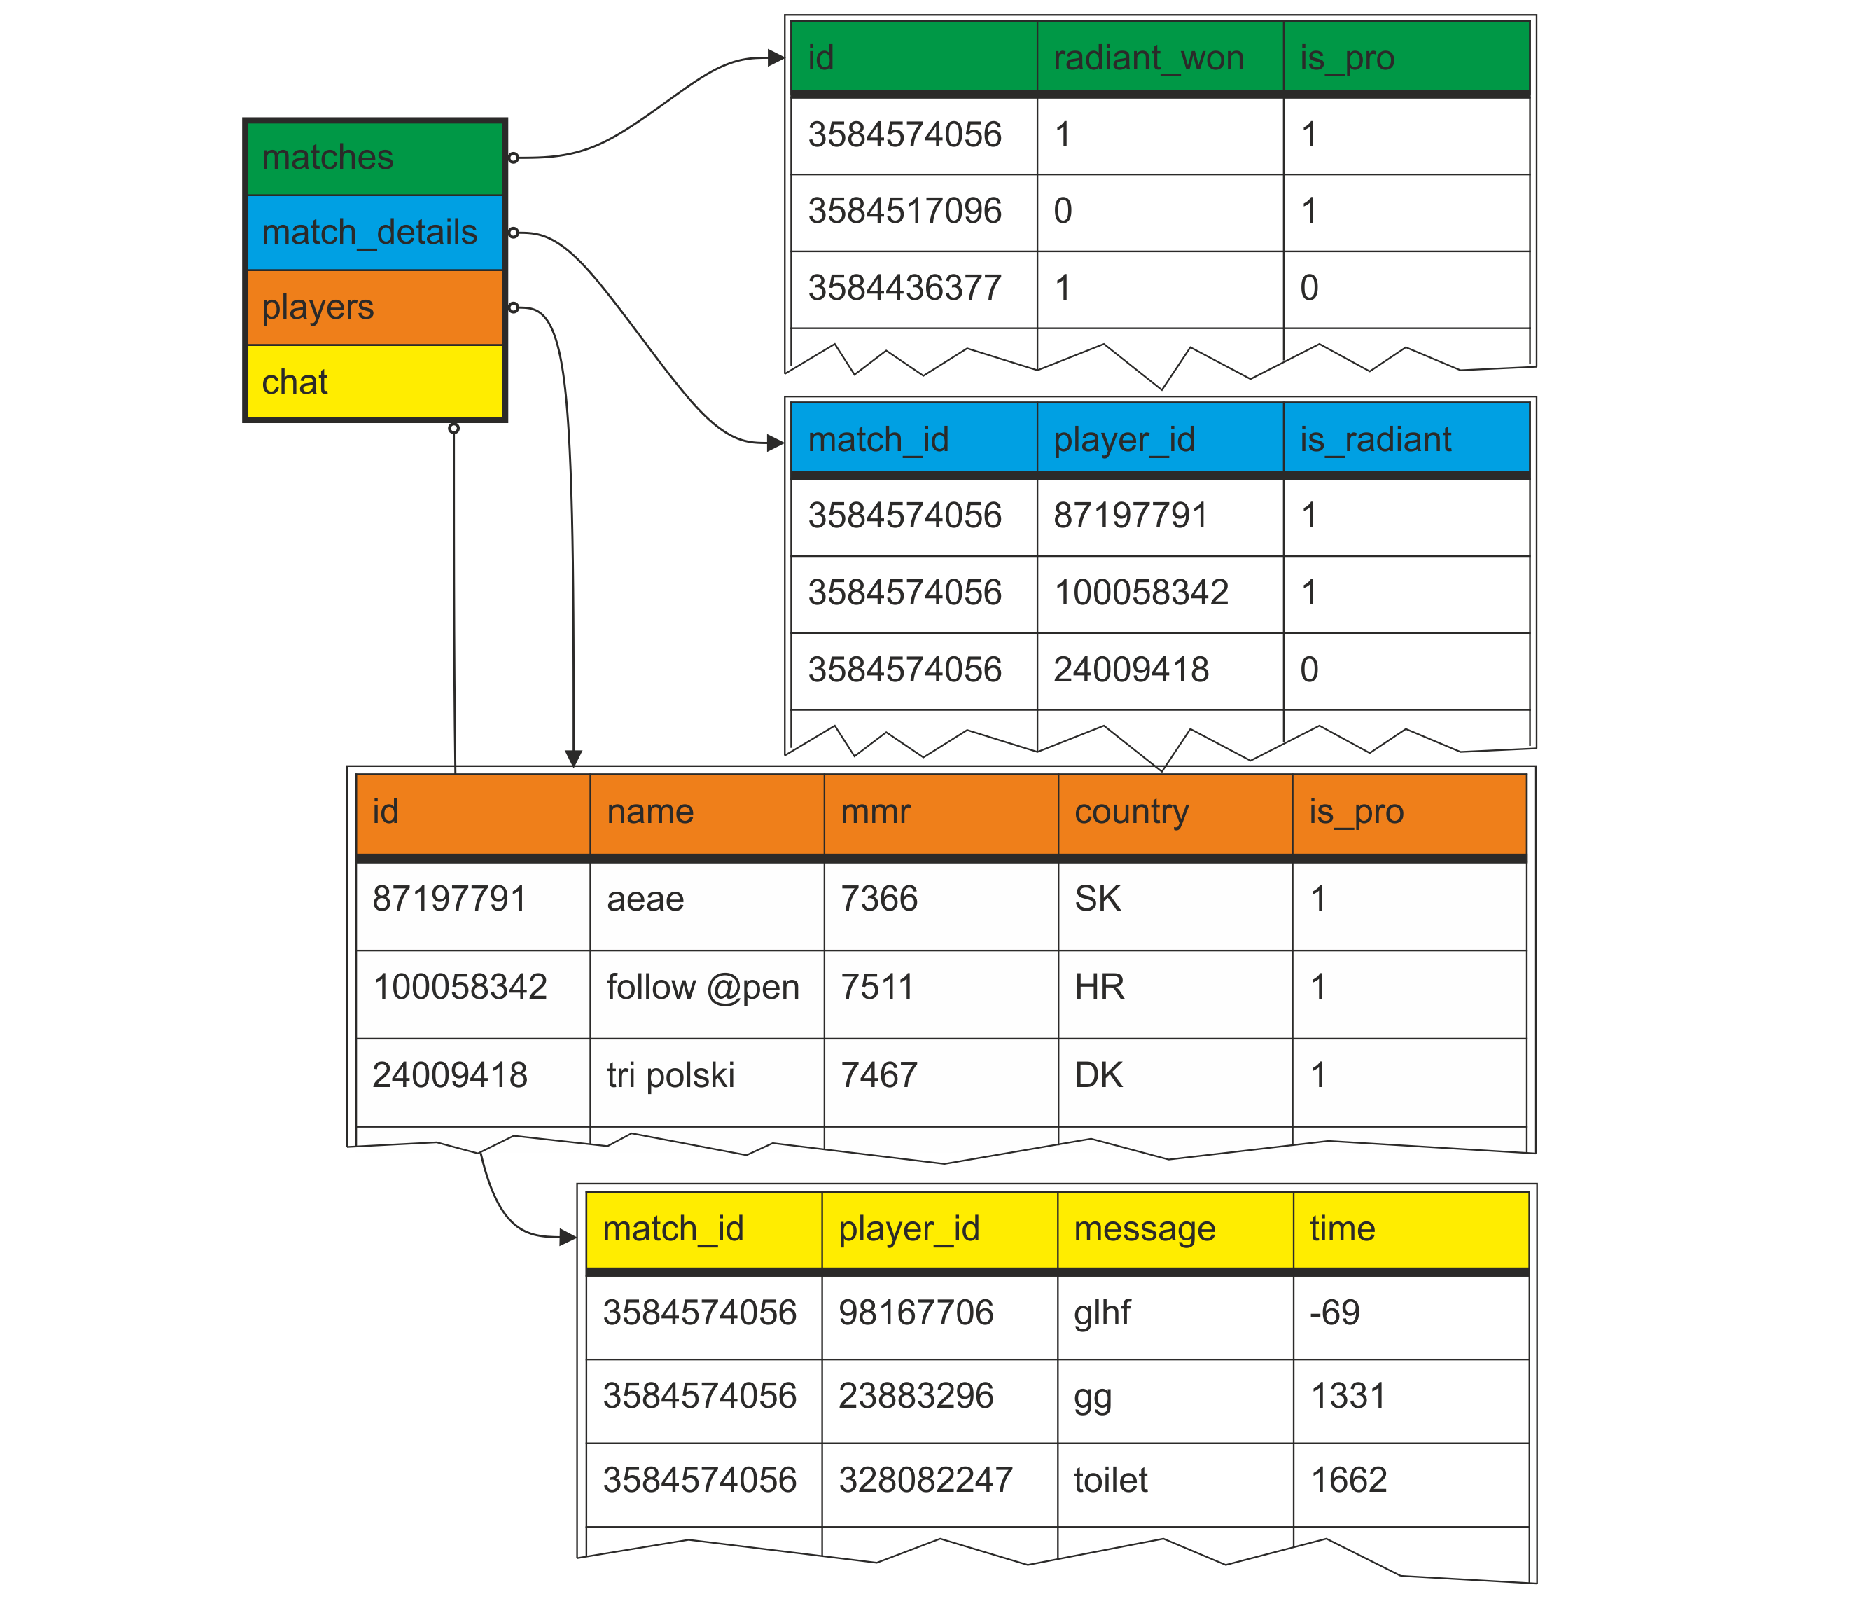

In [1]:
from IPython.display import Image
Image(filename='dota_db.png')

That's all for the introduction, let's continue with interesting part of the project.

# More about the dataset

Before starting the presentation of our project, a few more thing should be mentioned. First lets start with some descriptive data about our dataset. Through the before mention API more than 1800 dota matches and 3300 players were downloaded for further analysis. In the network analysis part we will concentrate only on pro players, the main reason behind this decision is that the country code is not defined for most non-pro players and this data will be used for community detection. Our graph has around 1300 nodes, each nodes representing a professional player and around 17000 edges. For the other part on the final project we gathered chat messages from pro and non-pro matches, around 17000 chat texts were downloaded, allowing us to perform interesting analysises from different point of views.

The following block contains the python code we used to collect the data, it was written in VSCode and executed from terminal, so we decided not to split up the code into parts, instead we went with an inline comment solution to explain what we did and why. PLEASE DON'T RUN IT!

In [ ]:
# necessary imports
from __future__ import division
import requests
import sqlite3

# This two line is only here to prevent our code from running accidentaly again and overwrite our db
# in the original code these weren't included
import sys
sys.exit()

# We created our database in the Pycharm IDE
# establish connection to our database
conn = sqlite3.connect('dota.db')
conn.text_factory = str
c = conn.cursor()

# This function inserts new rows to our match_details table
def add_match_details(match_details_data):
    try:
        # Construct the query format
        query = ''' INSERT INTO match_details(match_id,player_id,is_radiant)
                VALUES(?,?,?)'''
        # fill in the query for a whole array of tuples with (match_id, player_id, is_radiant) values and execute it
        # thus, inserting multiple rows at once
        c.executemany(query, match_details_data)
    finally:
        return

# This function inserts a new row to our chat table
def add_chat(chat_data):
    try:
        query = ''' INSERT INTO chat(match_id, player_id, message, time)
                VALUES(?,?,?,?)'''
        c.executemany(query, chat_data)
    finally:
        return

# This function receives a playerID, performs a request for further information,
# selects the relevant information and inserts it to the player table
def add_player(player_id, is_pro=False):
    response = requests.get('https://api.opendota.com/api/players/' + str(player_id)).json()
    try:
        # get only the relevant information
        profile = response['profile']
        name = profile['personaname']
        country = profile['loccountrycode']
        mmr = response['mmr_estimate']['estimate']

        query = ''' INSERT INTO players(id, name, mmr, country, is_pro)
                VALUES(?,?,?,?,?)'''
        # the 'execute' function inserts only one row compared to executemany
        c.execute(query, [player_id, name, mmr, country, is_pro])
    finally:
        return

# This function inserts a new row to our matches table
def add_match(match_id, radiant_won, is_pro):
    try:
        query = ''' INSERT INTO matches(id, radiant_won, is_pro)
                VALUES(?,?,?)'''
        c.execute(query, [match_id, radiant_won, is_pro])
    finally:
        return

# This function has an input of a matchID
def process_match(match_id, is_pro=False):
    # perform a request to get all the details of a specific game
    response = requests.get('https://api.opendota.com/api/matches/' + str(match_id)).json()
    radiant_win = response['radiant_win']
    players = {}

    # add this match to our matches table
    add_match(match_id, radiant_win, is_pro)

    match_details_data = []
    # for every element in the response['players'] list check if has an account_id key
    # every player without an account id is filtered out (since players can deny their account id to be shown).
    # players get a player_slot in each match, and they are referenced to through this value (eg. during chat), so we also need a 
    # dictionary to be able to look up which player_slot is which account.
    for player in filter(lambda player: player['account_id'], response['players']):
        # save the player to the database
        player_id = player['account_id']
        add_player(player_id, is_pro)
        # insert the player id into a dictionary, we will need that later
        players[player['player_slot']] = player_id
        # since every player is added to the match_details table at the same time (for performance optimization purposes), 
        # we make an array of all the players present in a specific match, and then later feed the whole array to the table.
        match_details_data.append((match_id, player_id, player['isRadiant']))

    # we use this table to connect the matches to the players and to store which side the player played during that game
    add_match_details(match_details_data)

    # the chat field in the api is only available for pro matches
    if response['chat']:
        chat_data = []
        # the input of the filter function is the response['chat'] list, containing dictionaries
        # for every element in the list, check the type is 'chat', this is necessary because dota has easily reachable build 
        # in text messages and we are not interested in them when working with text
        # the last criteria we check here is that the sender is defined in dictionary containing the infos about each msg    
        for chat_item in filter(lambda chat_item: chat_item['type'] == 'chat' and 'player_slot' in chat_item.keys(),
                                response['chat']):
            # if the sender is identified
            if chat_item['player_slot'] in players.keys():
                # save the message and some other relevant information (sender, timestamp and matchID)
                chat_data.append((match_id, players[chat_item['player_slot']], chat_item['key'], chat_item['time']))
        # When the whole game is processed from the chat point of view, save the data in the chat table
        add_chat(chat_data)

# this function is a bundler function, it basically get x matches that a player was involved in, and then processes all those matches
# We implemented this function, because all three of us played Dota earlier and we were curious abut our data also :)
def process_player(player_id, max_number_of_matches=100):
    sum_match = 0
    # get the player's matches
    response = requests.get('https://api.opendota.com/api/players/' + str(player_id) + '/matches').json()
    # work only with the last 100 games
    if len(response) > max_number_of_matches > 0:
        response = response[:max_number_of_matches]

    # just a simple variable for a simple 'progress bar' we use to monitor our progress, because the API we used was a bit slow
    length = len(response)
    # for every match returned by the API call call the process match function defined earlier
    for i, match in enumerate(response, start=1):
        print '\rFetching in progress... {0:.2f}%'.format(i / length * 100),
        try:
            process_match(match['match_id'])
            sum_match += 1
        except:
            pass

    print '\nA total of {} matches was added.'.format(sum_match)

# The other main function, it is used to gather pro matches, the input indicates how many API calls we want to perform
# one call will give us 100 matches.
def process_pro_matches(rounds):
    sum_match = 0
    url = 'https://api.opendota.com/api/proMatches'
    last_id = ''

    for i in range(rounds):
        # perform the request, get 100 matches and save the id of the last match,
        # so we can use it later for the next API call
        response = sorted([str(match['match_id']) for match in requests.get(url + last_id).json()])
        # the more recent a match is the bigger number it gets as a match_is. Thus, we make an ordered list to get the smallest
        # number easily. This match_id will be used in the next request, which will return another 100 matches that tooke place before
        # this given match_id
        last_id = '?less_than_match_id=' + response[0]

        #iterate through the results, and call the process match for every item
        for index, match_id in enumerate(response, start=1):
            print '\rFetching in progress... {0:.2f}%'.format((i + index / 100) / rounds * 100),
            try:
                process_match(match_id, is_pro=True)
                sum_match += 1
            except:
                pass

    print '\nA total of {} matches was added.'.format(sum_match)


# =========================================================================================

print 'Fetching started...\n'

# Get x pages of pro matches - expect that due to the slowness of the server around 1/10 matches will NOT be
# processed due to timeout error. One page contains 100 matches
process_pro_matches(1)

# Get matches of a particular player - same error can happen here. My profile contains 1062 matches - calculate
# with that in mind
# process_player(44030905)

# save the changes in the database
# it is ONLY commented out for the handin, to avoid overriding the original database
#conn.commit()

print '\n...done!'


# =========================================================================================


# The analysis

Setting up the IPython notebook and importing the necessary things...

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import sqlite3
import itertools
import community
import nltk
import re
import io
import random
import requests
import warnings
from os import path
from PIL import Image
from collections import Counter
from __future__ import division
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# getting rid of warnings...
warnings.simplefilter('ignore')

As the first step, let's create the graph. Each node will be a pro player, and the connection will be established whether they have played together (or against) or not. For this we are using our database.

In [3]:
# Getting access to the database
conn = sqlite3.connect('FinalProj/dota.db')
conn.text_factory = str
c = conn.cursor()

# Creating a graph containing the players
pro_players = nx.Graph()

# Iterate through the players found in the database
for row in c.execute('SELECT * FROM players WHERE is_pro=1'):
    pro_players.add_node(row[0], name=row[1], mmr=row[2], country=row[3])

# Get the match_ids from the matches table
match_ids = [match_id[0] for match_id in c.execute('SELECT id FROM matches WHERE is_pro=1')]

# Go throught the matches, get the player in them
for match_id in match_ids:
    players_together = [p[0] for p in c.execute('SELECT player_id FROM match_details WHERE match_id='+ str(match_id))]
    
    # Create all possible combination following the rule that these combination has to contain 2 elements
    # (according to the second parameter)
    all_combinations = list(itertools.combinations(players_together, 2))
    pro_players.add_edges_from(all_combinations)

Now let's take a look at the graph...

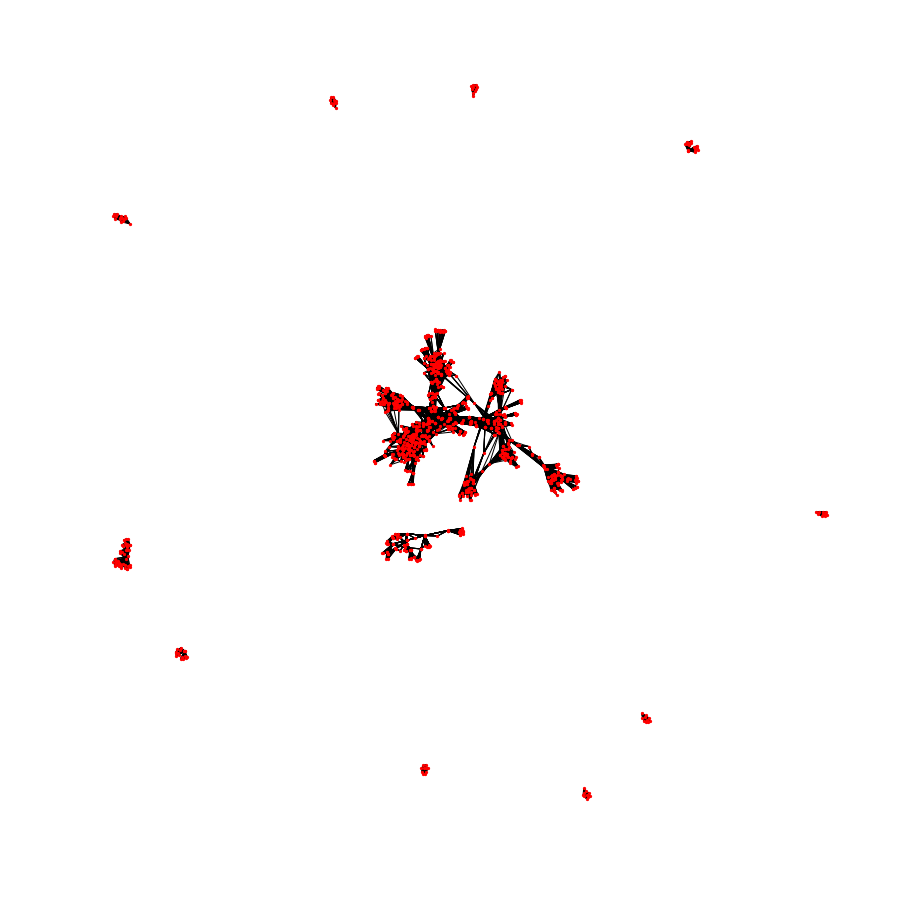

In [4]:
plt.figure(3,figsize=(12,12)) 
nx.draw(pro_players, node_size=5)
plt.show()

## Centrality analysis between pro players

At first we were courious about the most known and viral players. Therefore we applied several centrality analysis, which will provide us some interesting insights about the pro players in the world of dota. In order to be able to apply these techniques we needed to extract the giant connected component because centrality only works with a fully connected graph.

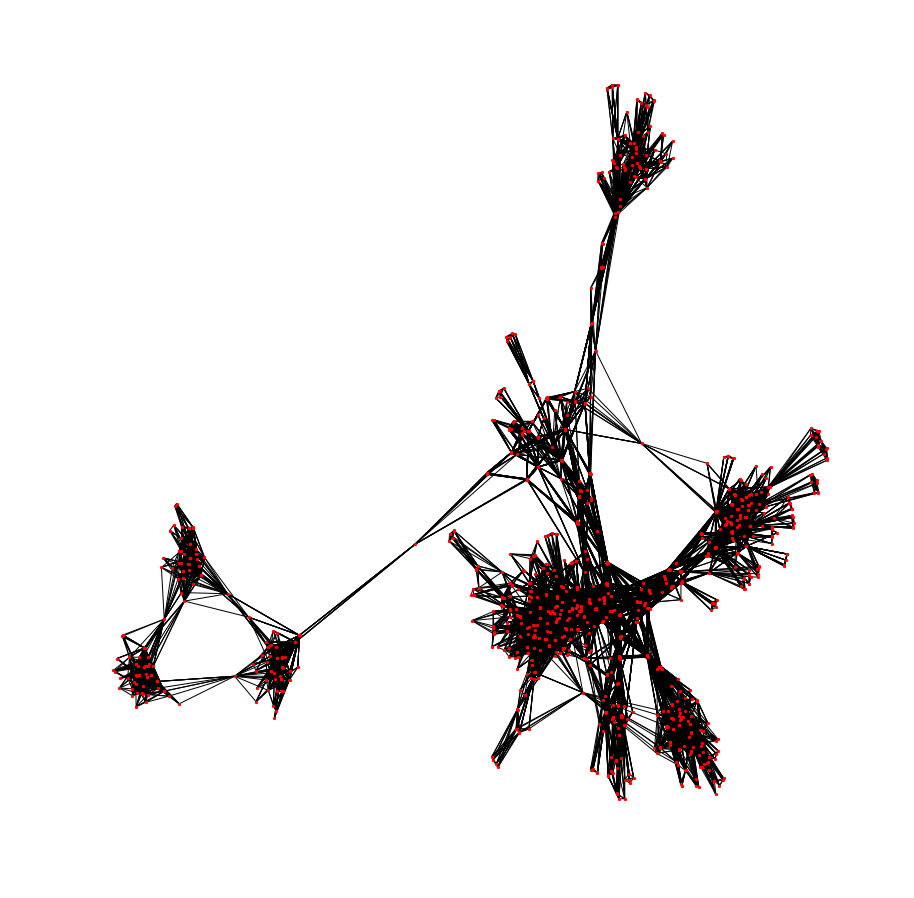

In [5]:
# Getting the giant connected component
Gccs=sorted(nx.connected_component_subgraphs(pro_players), key = len, reverse=True)
Gcc=Gccs[0]
plt.figure(3,figsize=(12,12))
nx.draw_spring(Gcc, node_size=5)
plt.show()

During our centraility analysis we checked:
* betweenness centrality, which gives us the ratio of how many of the shortests paths passes through each node,
* eigenvector centrality, which computes the centrality of a node based on its neighbours' centrality,
* deree centrality, which gives us a value between zero and one depending on the fraction of the nodes that are connected to the currently examined node.
* we also took a glance at the nodes with the highest degrees.

Instead of displaying numbers and user ids, we thought that it's better to display the player's name. This way every reader can search for the players online.

In [6]:
# This function returns the name of the player from the user id.
def get_player(id):
    return [ w[0] for w in c.execute('SELECT name FROM players WHERE id = ' + str(id))][0]

In [7]:
print "The top5 central Dota players (betweenness centrality):", ', '.join([get_player(w[0]) for w in Counter(nx.betweenness_centrality(Gcc)).most_common(5)])

The top5 central Dota players (betweenness centrality): Lubby, xRag ~ L   ҉҈..., 咻~咻~, Medal is life, Andre Astora


These players participate in the most shortest paths. Therefore they are centric and popular players.

In [8]:
print "The top5 central Dota players (eigenvector centrality):", ', '.join([get_player(w[0]) for w in Counter(nx.eigenvector_centrality(Gcc)).most_common(5)])

The top5 central Dota players (eigenvector centrality): YapzOr, Ace, Puppey, panda, Ori


These players had the chance to play with the most known players in the pro dota scene.

In [9]:
print "The top5 central Dota players (degree centrality):", ', '.join([get_player(w[0]) for w in Counter(nx.degree_centrality(Gcc)).most_common(5)])

The top5 central Dota players (degree centrality): YapzOr, Ace, Puppey, 自在极意功, HYNB!


These players have the most diverse player pool.

Let's investigate whether the network of dota players is a naturally distributed network or not. We can answer this question by plotting degree distribution curves. In order to have a better representation of the results, we will plot the degree distribution both on a linear and a logarithmic scale.

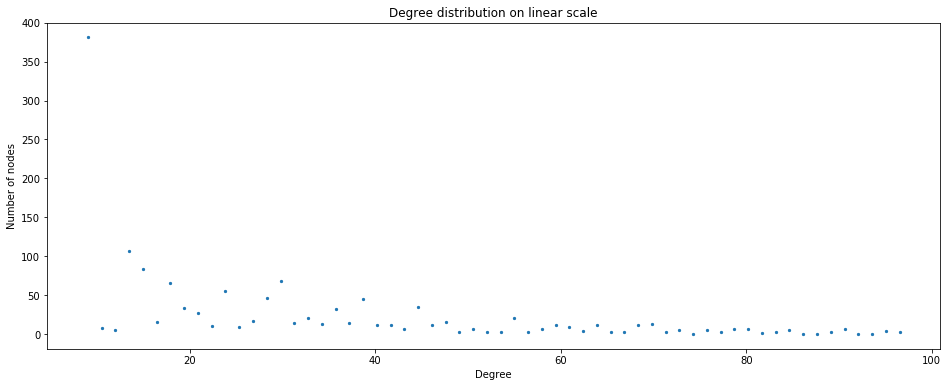

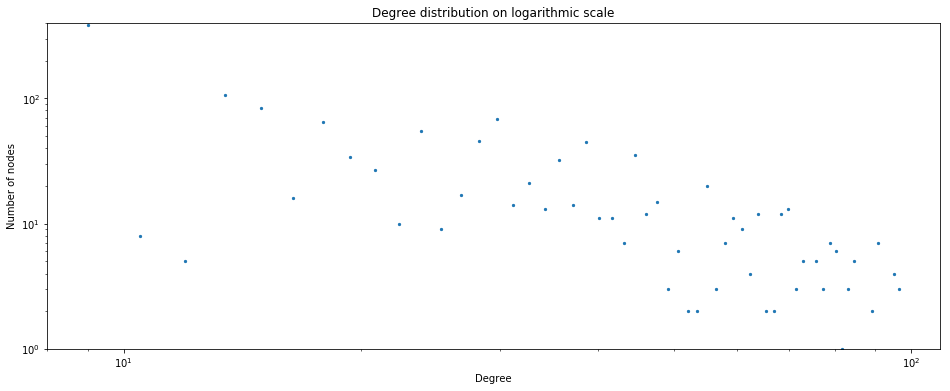

In [10]:
# Creating degree distribution plots
hist, bin_edges = np.histogram(nx.degree(pro_players).values(), bins=60)
bin_edges=bin_edges[0:60]

# Linear scale
plt.figure(1, figsize=(16, 6))
plt.scatter(bin_edges, hist, s=5)
plt.ylabel('Number of nodes')
plt.xlabel('Degree')
plt.title('Degree distribution on linear scale')

# Logarithmic scale
plt.figure(2, figsize=(16, 6))
plt.scatter(bin_edges, hist, s=5)
axes = plt.gca()
axes.set_ylim(ymin=1)
axes.set_xscale("log", nonposx='clip')
axes.set_yscale("log", nonposy='clip')
plt.ylabel('Number of nodes')
plt.xlabel('Degree')
plt.title('Degree distribution on logarithmic scale')

plt.show()

From the plots we can draw conclusion that the network has the characteristics of a natural network although there is a large scattering error.

## Community analysis between pro players

Now we turned our attention to look for communities in the network of pro players, our hypothesis is that based on geograophical separation there will be a clear division. In the game of Dota, when a player is about to start a game, the region will be automatically set from a predefined set of regions (length of this list: ~20) based on IP address. The other main reason behind  our hypothesis is that most of the pro players attend local tournaments hold yearly. We implemented the Louvain-algorithm to find communities in the full network of dota players.

In [6]:
# The following function calculates the modularity of the graph based on the equation in the book
def count_M(player_dict, graph):
    L = graph.number_of_edges()
    M_list = []
    for player_list in player_dict.values():
        sub_graph = graph.subgraph(player_list)
        Lc = sub_graph.number_of_edges()
        kc = sum(sub_graph.degree(player_list).values())
        Mc = (Lc/L) - (kc/(2 * L))**2
        M_list.append(Mc)
    return sum(M_list)

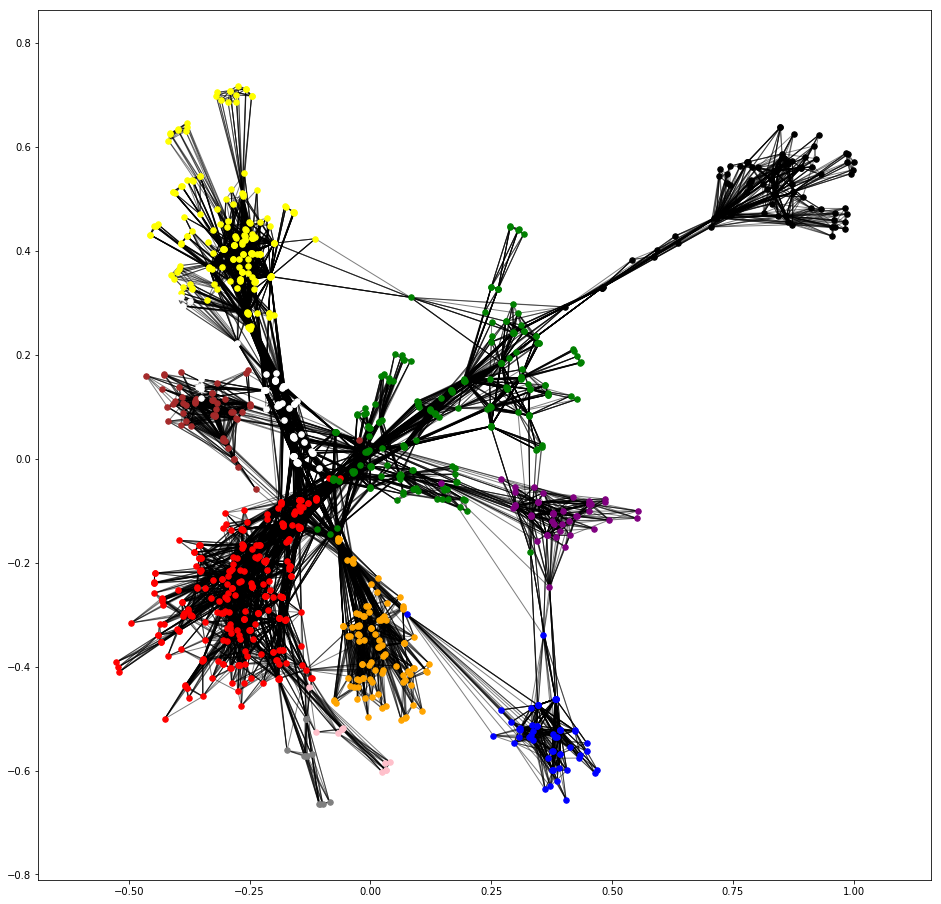

In [14]:
# First compute the best partition
partition = community.best_partition(Gcc)
community_sets = {}
colors = ['blue', 'red', 'green', 'yellow', 'brown', 'pink', 'black', 'white', 'orange', 'purple', 'gray']

# Drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(Gcc)
count = 0.

for index, com in enumerate(set(partition.values())):
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    community_sets[com] = set(list_nodes)
    plt.figure(3, figsize=(16, 16))
    #nx.draw_networkx_nodes(Gcc, pos, list_nodes, node_size = 30, node_color = str(count / size))
    nx.draw_networkx_nodes(Gcc, pos, list_nodes, node_size = 30, node_color = colors[index])

# Plotting
plt.figure(3, figsize=(16, 16))
nx.draw_networkx_edges(Gcc, pos, alpha=0.5)
plt.show()

On this graph the existing communities detected by the algorithm are clearly separated, we tried to visualize them using different colors.

In [13]:
print "The modularity of the graph:", count_M(community_sets, pro_players)

The degree of community detection: 0.699158324964


Let's process these communities further. During the data colelction we saved player's country, it is time to use it. For each detected community, get the countries paired with the users and make a set from it. Instead of showing country codes we are displaying country names, we achieve this with another API .

In [14]:
# Here we will get the nationalities of the given communities
communities = {}
regions = []

# First we create a dictionary to store the nationalities
for key, value in sorted(partition.iteritems()):
    communities.setdefault(value, []).append(key)

# Then for each community to add we gather the the nationalities
for index in communities:
    position = set()
    for user in communities[index]:
        c.execute('SELECT country FROM players WHERE id=' + str(user))
        country = c.fetchone()
        if country:
            if country[0] != None:
                position.add(country[0])
    regions.append(position)

In [15]:
# For each nationality we get the full name of the country. This way we can see the countries which make up the
# communities. 
for index,region in enumerate(regions):
    country_names = []
    print "Countries in community", index
    for country in region:
        response = requests.get('https://restcountries.eu/rest/v2/alpha/' + country).json()
        country_names.append(response['name'])
    print ', '.join(country_names), "\n"

Countries in community 0
Korea (Republic of), New Zealand, Australia, El Salvador 

Countries in community 1
Bulgaria, Denmark, Afghanistan, Japan, Canada, Bosnia and Herzegovina, United States of America, United States Minor Outlying Islands, Korea (Republic of), Angola, Brazil, Peru, Yemen, Sweden, China 

Countries in community 2
China, Virgin Islands (British), Canada, Australia, Malaysia, Belize 

Countries in community 3
China, Portugal, Viet Nam, New Zealand, Australia, United States of America 

Countries in community 4
France, Bulgaria, Denmark, Croatia, Turkey, Germany, Japan, Hungary, Dominica, Finland, Fiji, Belarus, Bosnia and Herzegovina, Russian Federation, Lebanon, Saint Lucia, Serbia, Malaysia, Timor-Leste, Romania, Poland, Guinea-Bissau, Greece, Estonia, Canada, Albania, Czech Republic, Australia, Israel, Spain, Jordan, Syrian Arab Republic, Ukraine, Norway, Slovakia, Korea (Democratic People's Republic of), Sierra Leone, Kazakhstan, Singapore, Sweden 

Countries in c

Some countries appear in multiple communities, the reason for this is that there are players who are located for example in Australia but plays most of the time with players from eastern countries. In this case Australia as a country will also appear in an Eastern community as well as probably in the community of Australia. 

## Text processing
During a game of dota, every player has the possibility to write messages to each other. In the following chapters we will use text processing to find the most used words of different player groups. We will divide the players based on the result of the game (whether they were on the winning side or on the losing side). Are they swearing more when they are losing? Are they couraging the others when they are losing?

Until now we only worked with pro players, from this point we will use all of our data gathered, including both pro and non-pro matches.

For an easy representation we are using the wordcloud library's built in function which keeps track of the most common words in a text. Additionally we have the option to use a set of stopwords, as well as extending it. We used this extending functionality to refine our results because there are very commonly used words and phrases which would appear in every wordcloud and may deform our results.

We are aware that with the usage of TF-IDF analysis these words can be naturally eliminated, but this would also get rid of the frequency differencies of the same word. Let's take the word 'sorry' as an example. This word is not descriptive, every bracket uses it therefore TF-IDF would eliminate it. But as we will see down below skilled players tend to use it a lot more than unskilled players which is a meaningful information.

In [16]:
# This function creates a wordcloud image (does not plot it just yet), based on the incoming raw text data. 
# With the second parameter, we can limit the number of words to use. These will be the most common words 
# in the text.
def create_wordcload_image_from_text(text, number_of_words):
    
    # Stopwords usage from the built in collection
    stopwords = set(STOPWORDS)

    # We extend it with some game-related words.
    stopwords.update(['gg', 'hf', 'ggg', 'gggg',
                      'ggggg', 'gggggg', 'gl', 'gggl',
                      'wp', 'wpgg', 'ggwp', 'gggggl',
                      'hfgggg', 'ggl', 'hfgggggl',
                      'hfgl', 'ggggggg', 'ggggglhf', 
                      'wpgl', 'glhf', 'gege', 'gl', 
                      'glgl', 'glglgl', 'sec', 'sorry',
                      'lag', 'rdy', 'sry'])
    
    # For the wordcloud creation we used the library called 'wordcloud'
    wc = WordCloud(background_color='white', max_words=number_of_words,
                   stopwords=stopwords, max_font_size=180, random_state=42)

    # Generate word cloud
    wc.generate(text)
    
    return wc

In [17]:
# This function is responsible to get the 'winned' team's comments and the 'loser' team's comments separately
# from the database. 
def get_comments(side):
    text = ''
    win = '0'
    if (side == 'win'):
        win = '1'
        
    # Query to get the comments from the database
    for row in c.execute(
        'SELECT message FROM chat '
            'INNER JOIN matches ON chat.match_id = matches.id '
            'INNER JOIN match_details ON ('
                'chat.player_id = match_details.player_id AND '
                'chat.match_id = match_details.match_id) '
                    'WHERE match_details.is_radiant = 1 AND matches.radiant_won = ' + win):
        
            # We accumulate the comments into one big text
            text += (' ' + row[0].decode('utf-8').lower())

    return text

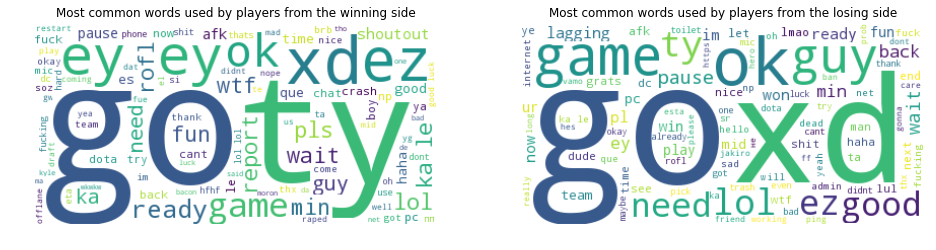

In [18]:
# Create a grid of two plots in a row with a given size
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Get the appropriate comments from the database
winner_comments = get_comments('win')
loser_comments = get_comments('lose')

# Show the wordclouds
ax[0].imshow(create_wordcload_image_from_text(winner_comments, 100), interpolation='bilinear')
ax[0].axis("off")
ax[0].set_title('Most common words used by players from the winning side')
ax[1].imshow(create_wordcload_image_from_text(loser_comments, 100), interpolation='bilinear')
ax[1].axis("off")
ax[1].set_title('Most common words used by players from the losing side')
fig.subplots_adjust(hspace=0.3)
plt.show()

As experienced dota 2 players we can easily reflect on these results. In an average game, before a huge teamfight someone always asks whether we should start the initiation or not. This is why 'go' is very popular in both cases. If the fight was succesfull, we congratulate each other for the perfect execution, timing and item usage by saying 'ty', which is a short version of 'thank you'.

On the other side, most of the time after a lost teamfight we either laugh at our mistakes by typing 'xd' or 'lol' or use excuses like 'lagging', or occasionaly we flame each other.

The next division will be based on player skills. The game keeps track of different players skills. This is represented with a number called Match Making Rank (MMR) which can be between ~1000 and ~9000, the bigger the better. Usually professional players are above 7000 and casual gamers are below it.

Our hypothesis is that as a player gets better and better the most commonly used words are getting more supportive and the most flameing takes place in lower levels. Let's test this idea in the next blocks...

In [19]:
# This function returns an image for a wordcloud (does not plot it yet)
# between the given mmr levels. MMR = Match making rank, which is basically
# a number which indicates the level of gaming skills.
def get_word_cloud_between_mmr(mmr1, mmr2, number_of_words):
    text = ''

    for row in c.execute(
        'SELECT message FROM chat '
            'INNER JOIN players ON chat.player_id = players.id '
                    'WHERE players.mmr BETWEEN ' + str(mmr1) + ' AND ' + str(mmr2)):
            text += (' ' + row[0].decode('utf-8').lower())

    return create_wordcload_image_from_text(text, number_of_words)

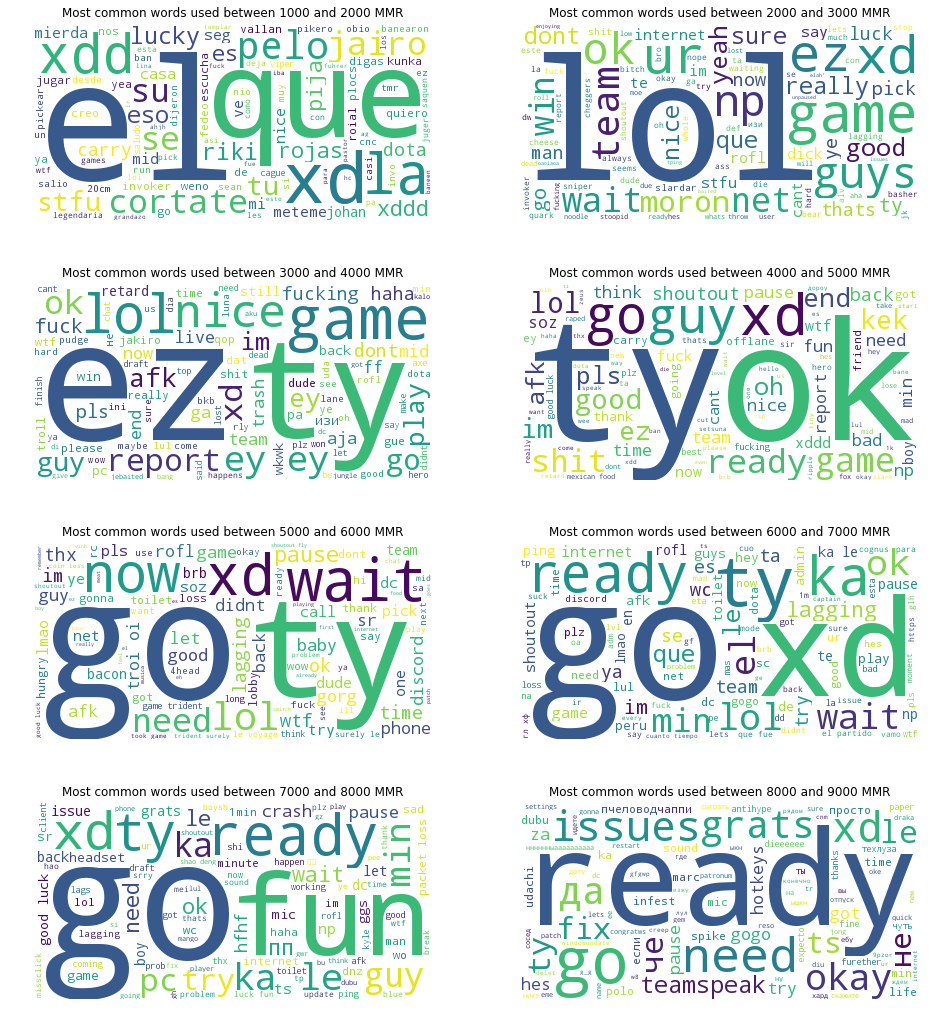

In [20]:
# Create a grid of plots
fig, ax = plt.subplots(4, 2, figsize=(16, 18))

# Show the wordclouds
ax[0, 0].imshow(get_word_cloud_between_mmr(1000, 2000, 100), interpolation='bilinear')
ax[0, 0].axis("off")
ax[0, 0].set_title('Most common words used between 1000 and 2000 MMR')

ax[0, 1].imshow(get_word_cloud_between_mmr(2000, 3000, 100), interpolation='bilinear')
ax[0, 1].axis("off")
ax[0, 1].set_title('Most common words used between 2000 and 3000 MMR')

ax[1, 0].imshow(get_word_cloud_between_mmr(3000, 4000, 100), interpolation='bilinear')
ax[1, 0].axis("off")
ax[1, 0].set_title('Most common words used between 3000 and 4000 MMR')

ax[1, 1].imshow(get_word_cloud_between_mmr(4000, 5000, 100), interpolation='bilinear')
ax[1, 1].axis("off")
ax[1, 1].set_title('Most common words used between 4000 and 5000 MMR')

ax[2, 0].imshow(get_word_cloud_between_mmr(5000, 6000, 100), interpolation='bilinear')
ax[2, 0].axis("off")
ax[2, 0].set_title('Most common words used between 5000 and 6000 MMR')

ax[2, 1].imshow(get_word_cloud_between_mmr(6000, 7000, 100), interpolation='bilinear')
ax[2, 1].axis("off")
ax[2, 1].set_title('Most common words used between 6000 and 7000 MMR')

ax[3, 0].imshow(get_word_cloud_between_mmr(7000, 8000, 100), interpolation='bilinear')
ax[3, 0].axis("off")
ax[3, 0].set_title('Most common words used between 7000 and 8000 MMR')
 
ax[3, 1].imshow(get_word_cloud_between_mmr(8000, 9000, 100), interpolation='bilinear')
ax[3, 1].axis("off")
ax[3, 1].set_title('Most common words used between 8000 and 9000 MMR')

fig.subplots_adjust(hspace=0.3)
plt.show()


As we can see on the lowest levels people can't even write properly. The typos are frequent and most words do not make sense. No constructive or supporting words are present. (MMR: 1000 - 2000)

Let's merge the next two brackets and analyse them together. 'lol' is often used after mistakes, this refers to the frequently committed mistakes by amateur players. Dota players use 'ez' to annoy the enemy team after conquering them in a fight ('ez' is the short version for 'easy'). This is psychological warfare at its finest! (MMR: 2000 - 4000)

For the next brackets more and more strategic words appear. This clearly indicates the increasing level of skills. Words like 'now', 'wait', 'go', 'ok' or positive feedback for team mates as 'ty'. This bracket introduces the idea of team play. (MMR: 4000 - 6000)

In the last category people extensive rely on team play. The word 'teamspeak' appears which is a famous platform similar to skype mainly used by gamers for in game communication. 'fun' also comes back, this represents that the people in this group enjoy gaming while delivering a high level of gaming. (MMR: 6000 - 9000)

Now let's see if we can find representative words for the different nationalities! We chose three countries with the biggest dota community and Hungary as our home country, to make the project more personal.

In [27]:
# This function creates a wordcloud with the words used by a given nationality
def get_wordcloud_of_nationality(country_code, number_of_words):
    text = ''

    for row in c.execute(
        'SELECT message FROM chat '
            'INNER JOIN players ON chat.player_id = players.id '
            'WHERE players.country="' + country_code + '"'):
            text += (' ' + row[0].decode('utf-8').lower())

    return create_wordcload_image_from_text(text, number_of_words)

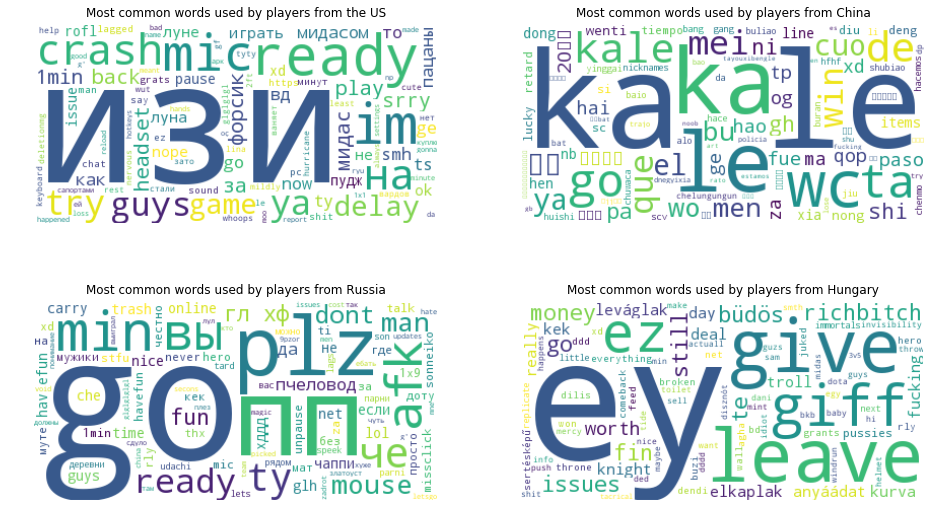

In [22]:
# Create a grid of plots
fig, ax = plt.subplots(2, 2, figsize=(16, 9))

# Show the wordclouds
ax[0, 0].imshow(get_wordcloud_of_nationality('US', 100), interpolation='bilinear')
ax[0, 0].axis("off")
ax[0, 0].set_title('Most common words used by players from the US')

ax[0, 1].imshow(get_wordcloud_of_nationality('CN', 100), interpolation='bilinear')
ax[0, 1].axis("off")
ax[0, 1].set_title('Most common words used by players from China')

ax[1, 0].imshow(get_wordcloud_of_nationality('RU', 100), interpolation='bilinear')
ax[1, 0].axis("off")
ax[1, 0].set_title('Most common words used by players from Russia')

ax[1, 1].imshow(get_wordcloud_of_nationality('HU', 100), interpolation='bilinear')
ax[1, 1].axis("off")
ax[1, 1].set_title('Most common words used by players from Hungary')

fig.subplots_adjust(hspace=0.3)
plt.show()

The first wordcloud is the words most frequently used in the United States. And we are glad to scientifically prove that a lot of Russian players play on American servers. This is a widely known phenomenon in the dota community and the main reason behind it, is that Russian players tend to be lower skilled than others. Therefore the servers are mainly filled with low level players, from which a lot of them are trying to escape to the most skilled servers: are the American ones. This eventually leads to a flood of Russian players in America.

On the next image we can see that Asian dota is not English based. This culture is so different than any other, that even casters and professional players use to say 'Chinese dota' for their gaming style.

The third chart is from Russia, here we can see that most of the words are using cyrillic characters. To be honest, we does not understand any of it...

The last picture represents our home country. Here we would like to provide some basic cultural information. For example the word 'ey' is the hungarian representatin of the word 'ez', we use 'y' instead of 'z' because of the Hungarian keyboard is a 'QUERZ' keyboard and not a 'QUERTY'. Most of the hungarian words are swearing in various style, we think it's not necessary to analyse them now.

## Sentiment analysis

Now we wanted to find out whether being on the winning side makes people happier than being on the losing side. We do this by applying sentiment analysis on the comments of each side. For the analysis we are using the labMT word list to get a dictionary of the happiness levels of different words.

In [23]:
# Sentiment analysis based on the labMT wordlist
happiness_dict_raw = io.open('./Data_Set_S1.txt', 'r', encoding='utf-8').read().split('\n')
happiness_dict = {}

# Creating a dictionary to store the happiness values for each word.
for index, line in enumerate(happiness_dict_raw):
    splitted_line = line.split('\t')
    happiness_dict[splitted_line[0]] = splitted_line[2]

# This function evaluates an array of words and returns their overall happiness based on
# the data from the labMT wordlist. It can be configured to throw an error when it does
# not find any word with happiness value
def evaluate_words(words, error_alert):
    
    # we rely on the happiness dictionary
    global happiness_dict
    happiness = 0
    
    # Go through the words and look up each of them in the happiness dictionary. 
    for word in words:
        if word in happiness_dict:
            happiness += float(happiness_dict[word])
    if (happiness == 0 and error_alert):
        return 'No sentiment in the sentence!'
    return happiness

In [24]:
# This function returns a plot data of happiness as a moving average in a text which
# must be added as an array of words. STEP specifies the stepsize of the moving average
def get_happiness_data_in_text(text, STEP):
    formatted_text = [ w.lower() for w in text ]
    x = []
    y = []
    
    # let's go through the text in STEP size steps...
    for idx, words in enumerate(formatted_text[::STEP]):
    
        happiness = 0
        
        # handling the case when we reach the end of the file
        if((idx * STEP + STEP) < len(formatted_text)):
            happiness = evaluate_words(formatted_text[idx * STEP:idx * STEP + STEP], False)
        else:
            happiness = evaluate_words(formatted_text[idx * STEP: len(formatted_text)], False)

        # creating the two datasets fot the plot...
        x.append(idx * STEP)
        y.append(happiness)
    
    return x, y

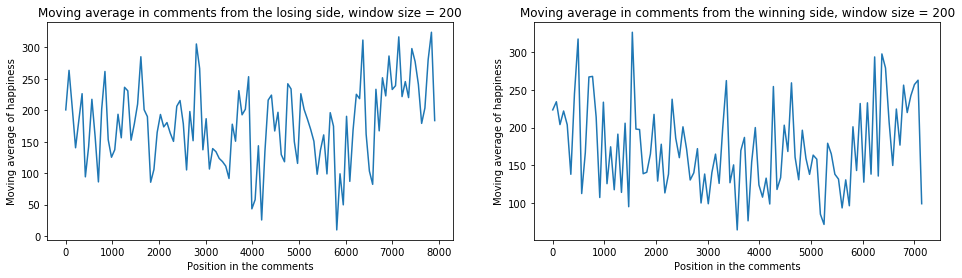

In [25]:
# Here we create two plots of the overall happiness values in the comments of the losing side and the winning side

words_win = nltk.word_tokenize(get_comments('win'))
words_lose = nltk.word_tokenize(get_comments('lost'))

# loser side
f, axarr = plt.subplots(1,2,figsize=(16,4))
x, y = get_happiness_data_in_text(words_lose, 70)

axarr[0].plot(x, y)
axarr[0].set_title('Moving average in comments from the losing side, window size = 200')
axarr[0].set_xlabel('Position in the comments')
axarr[0].set_ylabel('Moving average of happiness')

# winning side
x, y = get_happiness_data_in_text(words_win, 70)
axarr[1].plot(x, y)
axarr[1].set_title('Moving average in comments from the winning side, window size = 200')
axarr[1].set_xlabel('Position in the comments')
axarr[1].set_ylabel('Moving average of happiness')

f.subplots_adjust(hspace=0.3)
plt.show()

We expected that there will be a clear difference on the levels of happiness, but this provided us no useful information, because we can't just see the difference between the levels. Therefore we tried to measure the average levels of happiness.

In [26]:
# Here we calculate the overall happiness values of the two sets of comments (winning and losing side)
def get_average_happiness(tokenized_words):
    return (evaluate_words(tokenized_words, False) / len(tokenized_words))

print 'Average happiness in comments made by the winning side: ', get_average_happiness(words_lose)
print 'Average happiness in comments made by the losing side: ', get_average_happiness(words_win)

Average happiness in comments made by the winning side:  2.55686644051
Average happiness in comments made by the losing side:  2.49209798995


As we can see the winning side is a little bit happier but the difference is minor. I think it's safe to say that our initial hypothesis turned out not to be true due the lack of evidence. People enjoy dota no matter of losing or winning.

# Conclusion

Working with this dataset was interesting for us from the very beggining, hope by reaching the last part our reader also thinks this way. 

The first part contained the network analysis. After evaluating the players from different types of centrality analysis, we tested our results with some friends who are still active players. The names we showed them vere 80% familiar for them, so we can say that our results are validated. The network of Dota2 players was expected to be a natural network, although the plotted degree distribution didn't validated our hypothesis clearly. Probably extending the dataset would improve the shape of our diagram. For the community analysis the modularity of the graph was calculated for the purpose of validation. 

In the text processing section the wordclouds we achieved were familiar for us, we used these short messages a lot when we were active players also. They provide a very clear and valid picture about avarage chat messages during a game. The last task was about sentiment analysis, here we had some minor problems with the results. Our expectations were different, we thought the difference will be bigger between the happiness level in case of won and lost matches. However, according to our results Dota doesn't make people happy :( . Anyway, probably these values will also be more precize in case of a bigger dataset.

Thanks for hanging with us, hope you enjoyed our topic.

Imre Nagy, Horvath Daniel, Lorant Gulyas